In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader
from datetime import datetime, timedelta

In [6]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import backend as K

In [7]:
import tensorflow as tf
import random as rn
import os

# Un intento de hacer resultados reproducibles
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
tf.compat.v1.set_random_seed(1234)

In [8]:
import pickle

In [37]:
# Agregado V2.0
global _showMessage
global _plot
global _folder

_showMessage = True
_plot = True
_folder = 'MIV05'

os.makedirs(_folder, exist_ok=True)

def saveScaler(ticker, scaler):
    file_name = os.path.join(_folder, ticker + '.pkl')
    with open(file_name, 'wb') as f:
        pickle.dump(scaler, f)
    return

def loadScaler(ticker):
    file_name = os.path.join(_folder, ticker + '.pkl')
    with open(file_name, 'rb') as f:
        return pickle.load(f)  
    
def showMessage(*args):
    message = ''
    
    if _showMessage:
        for value in args:
            message = message + str(value).strip() + ' '
        print(message)

In [19]:
def crearSerie(ticker, start='2012-01-01', end=datetime.now(), window_size=60, forecastDays=5):
    # Obtener cotizaciones desde yahoo finance
    df = DataReader(ticker, data_source='yahoo', start=start, end=end)
    # Truno el df para que el tamaño sea múltiplo de forecastDays
    borrar = df.shape[0] - (int(np.trunc(df.shape[0] / forecastDays)) * forecastDays) + 1
    df = df.truncate(after=df.tail(borrar).index[0]).copy(deep=True)
    # Vamos a utilizar los valores del cierre
    data = df.filter(['Close'])
    # Obtener valores como array de numpy
    dataset = data.values
    # Obtener el número de filas que se utilizarán para el entrenamiento
    training_data_len = (int(np.trunc(int(np.ceil( len(dataset) * .8 )) / forecastDays)) * forecastDays)

    # Llevar los valores a escala entre 0 y 1
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    
    # Nos guardamos el scaler para utilizarlo en las predicciones (Agregado V2.0)
    saveScaler(ticker, scaler)
        
    # Obtener los valores de entrenamiento
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []

    # Divido los datos de train en x_train e y_train
    # Vamos a usar bloques de window_size
    for i in range(window_size, len(train_data), forecastDays):
        x_train.append(train_data[i-window_size:i, 0])
        y_train.append(train_data[i:i+forecastDays, 0])
    
    # Se conviertes x_train e y_train a numpy array
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Se hace reshape de x_train
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
   
    # Se crea dataset para testing
    test_data = scaled_data[training_data_len - window_size: , :]
    x_test = []
    for i in range(window_size, len(test_data) - forecastDays, forecastDays):
        x_test.append(test_data[i-window_size:i, 0])

    ytest_data = dataset[training_data_len: , :]
    y_test = []
    for i in range(forecastDays, len(ytest_data), forecastDays):
        y_test.append(ytest_data[i-forecastDays:i, 0])

    # Convierte x_test a numpy array
    x_test, y_test = np.array(x_test), np.array(y_test)

    # Se hace reshape de x_test
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    
    # Última ventana de tiempo (train_size)
    x_forecast = []
    x_forecast.append(scaled_data[len(dataset) - window_size: , 0])
    x_forecast = np.array(x_forecast)
    x_forecast = np.reshape(x_forecast, (x_forecast.shape[0], x_forecast.shape[1], 1))
        
    return scaler, x_train, y_train, x_test, y_test, data, scaled_data, training_data_len, x_forecast

In [20]:
def crearModelo(window_size, loss='mae', optimizer='adam', metrics=['mae'], forecastDays=5):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (window_size, 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(forecastDays))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)    
    return model

In [21]:
def entrenarModelo(
        tickerPredecir, 
        start='2012-01-01', 
        end=datetime.now(), 
        window_size=60,
        loss='mae', 
        optimizer='adam', 
        metrics=['mae'], 
        epochs=30, 
        batch_size=32,
        validation_split=0.1,
        callbacks=[],
        forecastDays=5):

    showMessage('Crear serie ', tickerPredecir)
    scaler, x_train, y_train, x_test, y_test, data, scaled_data, training_data_len, x_forecast = crearSerie(tickerPredecir, start, end, window_size, forecastDays)
   
    showMessage('Crear modelo ', tickerPredecir)
    modelo = crearModelo(window_size, loss=loss, optimizer=optimizer, metrics=metrics, forecastDays=forecastDays)

    showMessage('Entrenar modelo')
    history = modelo.fit(x_train, y_train,
                          epochs=epochs, batch_size=batch_size,
                          validation_split=validation_split, callbacks=[es])
   
    showMessage('Evaluar modelo multi input')
    modelo.evaluate(x_test, y_test)
    
    showMessage('Testear modelo multi input')
    predictions = modelo.predict(x_test)
    
    # Transformación inversa de los valores predichos a la escala de la serie
    predictions = scaler.inverse_transform(predictions)

    showMessage('')
    showMessage('')
    showMessage('MAE (Mean Absolute Error): ', mean_absolute_error(y_test, predictions))
    showMessage('')
    showMessage('')
    
    arr_predictions = np.array([])
    for i in range(0, len(predictions)):
        arr_predictions = np.append(arr_predictions, predictions[i])
    
    if _plot:
        # Ploteamos los datos
        train = data[:training_data_len]
        valid = data[training_data_len:-1*forecastDays]
        valid['Predictions'] = arr_predictions
        plt.figure(figsize=(16,8))
        plt.title('Model')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close Price USD ($)', fontsize=18)
        plt.plot(train['Close'])
        plt.plot(valid[['Close', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()    
    
    # Guardamos los pesos para utilizar en futuras predicciones
    modelo.save_weights(os.path.join(_folder, tickerPredecir + ".h5"))
    
    return { 
        'modelo': modelo, 
        'scaler': scaler, 
        'x_train': x_train, 
        'y_train': y_train, 
        'x_test': x_test, 
        'y_test': y_test, 
        'data': data, 
        'scaled_data': scaled_data, 
        'training_data_len': training_data_len, 
        'x_forecast': x_forecast }

In [22]:
def crearModeloMI(models, loss='mae', optimizer='adam', metrics=['mae'], forecastDays=5):
    model_outputs = []
    model_inputs = []
    
    for model in models.values():
        model_outputs.append(model['modelo'].output)
        model_inputs.append(model['modelo'].input)

    # Concatenamos las salidas
    concat = concatenate(model_outputs)

    # Generamos una única salida con una sola neurona densa lineal
    final_output = Dense(forecastDays)(concat)

    # Creamos la instancia del modelo multi-input
    # Al haber múltiples entradas, definimos una lista de inputs
    multi_input_model = Model(model_inputs, final_output)
    
    # Ploteamos el modelo
    plot_model(multi_input_model, rankdir='LR')
    
    # Compilamos el modelo multi-input
    multi_input_model.compile(loss=loss,
                              optimizer=optimizer,
                              metrics=metrics)    
    return multi_input_model    

In [23]:
def entrenarModeloMI(
        tickerPredecir, 
        models,
        start='2012-01-01', 
        end=datetime.now(), 
        window_size=60,
        loss='mae', 
        optimizer='adam', 
        metrics=['mae'], 
        epochs=30, 
        batch_size=32,
        validation_split=0.1,
        callbacks=[],
        forecastDays=5):
    model_outputs = []
    model_inputs = []
    arr_train = []
    arr_test = []   
    arr_forecast = []
    
    for model in models.values():
        model_outputs.append(model['modelo'].output)
        model_inputs.append(model['modelo'].input)
        arr_train.append(model['x_train'])
        arr_test.append(model['x_test'])
        arr_forecast.append(model['x_forecast'])

    # Creamos el modelo multi input
    multi_input_model = crearModeloMI(models, loss, optimizer, metrics, forecastDays)
   
    # Datos de la serie a predecir
    y_train = models[tickerPredecir]['y_train']
    y_test = models[tickerPredecir]['y_test']
    
    # Agregado V2.0
    scaler = loadScaler(tickerPredecir) 
    
    data = models[tickerPredecir]['data']
    training_data_len = models[tickerPredecir]['training_data_len']
    
    # Entrenamos el modelo multi-input
    showMessage('Entrenar modelo multi input')
    history = multi_input_model.fit(arr_train, y_train,
                          epochs=epochs, batch_size=batch_size,
                          validation_split=validation_split, callbacks=[es])

    # Guardamos los pesos para futuras predicciones
    multi_input_model.save_weights(os.path.join(_folder, tickerPredecir + "_MI.h5"))
    
    # Evaluamos el modelo en test
    showMessage('Evaluar modelo multi input')
    multi_input_model.evaluate(arr_test, y_test)
    
    # Predecimos
    showMessage('Testear modelo multi input')
    predictions = multi_input_model.predict(arr_test)
    
    # Transformación inversa de los valores predichos a la escala de la serie
    predictions = scaler.inverse_transform(predictions)

    #Obtenemos el MAE
    showMessage('')
    showMessage('')
    showMessage('MAE (Mean Absolute Error): ', mean_absolute_error(y_test, predictions))
    showMessage('')
    showMessage('')
    
    arr_predictions = np.array([])
    for i in range(0, len(predictions)):
        arr_predictions = np.append(arr_predictions, predictions[i])
    
    if _plot:
        # Ploteamos los datos
        train = data[:training_data_len]
        valid = data[training_data_len:-1*forecastDays]
        valid['Predictions'] = arr_predictions
        plt.figure(figsize=(16,8))
        plt.title('Model')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close Price USD ($)', fontsize=18)
        plt.plot(train['Close'])
        plt.plot(valid[['Close', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()    
    
    return multi_input_model, history, valid

In [24]:
# Modificado V2.0
def crearDatosForecast(ticker, window_size=60, loss='mae', optimizer='adam', metrics=['mae'], forecastDays=5):
    # Preparamos el modelo y los datos utilizados para realizar las predicciones
    # Creamos el modelo
    modelo = crearModelo(window_size, loss, optimizer, metrics, forecastDays)
    # Leemos los pesos guardados anteriormente
    modelo.load_weights(os.path.join(_folder, ticker + '.h5'))
    # Se descargar los datos de la serie pero solo de los últimos dos períodos (largo de la ventana * 2)
    df= DataReader(ticker, data_source='yahoo', start=datetime.now() - timedelta(window_size * 2))
    # Creamos una entrada en un diccionario con la clave del ticker. Incluimos el modelo, la serie con valores del cierre
    # y un vector con los valores del cierre
    data_dic = { 
        'modelo': modelo,
        'data': df.filter(['Close']),
        'dataset': df.filter(['Close']).values}

    # Agregado V2.0
    scaler = loadScaler(ticker)
    data_dic['scaler'] = scaler
    data_dic['scaled_data'] = scaler.fit_transform(data_dic['dataset'])
    return data_dic

def forecast(tickerPredecir, tickersPredictores, forecastPeriods, window_size=60, loss='mae', optimizer='adam', metrics=['mae'], forecastDays=5):
    models = {}
    model_outputs = []
    model_inputs = []
   
    # Creamos el modelo, obtenemos los datos de la serie y escalamos los datos 
    models[tickerPredecir] = crearDatosForecast(tickerPredecir, window_size, loss, optimizer, metrics, forecastDays)
   
    for tickerPredictor in tickersPredictores:
        # Creamos el modelo, obtenemos los datos de la serie y escalamos los datos 
        models[tickerPredictor] = crearDatosForecast(tickerPredictor, window_size, loss, optimizer, metrics, forecastDays)
        
    multi_input_model = crearModeloMI(models, 'mae', 'adam', ['mae'], forecastDays)
    multi_input_model.load_weights(os.path.join(_folder, tickerPredecir + '_MI.h5'))
    
    arr_predictions = np.array([])

    for i in range(0, forecastPeriods):
        arr_forecast = []
        
        # Por cada ticker generamos la serie de datos que vamos a utilizar para predecir un día en el futuro
        for key, value in models.items():
            showMessage('ticker: ', key)
            scaled_data = value['scaled_data']
            x_forecast = []
            # Obtenemos los datos previamente escalados para la última ventana de tiempo de la serie
            x_forecast.append(scaled_data[len(scaled_data) - window_size: , 0])
            x_forecast = np.array(x_forecast)
            x_forecast = np.reshape(x_forecast, (x_forecast.shape[0], x_forecast.shape[1], 1))
            arr_forecast.append(x_forecast)
            
            # Si el ticker no es el que vamos a predecir con el modelo multi input, entonces
            # predecimos un día en el futuro para la serie
            # Esto es necesario para seguir prediciendo con el modelo multi input días siguientes ya que el input del modelo multi input
            # debe contener los datos de todas las series utilizadas para la predicción
            if key != tickerPredecir:
                predictions = value['modelo'].predict(x_forecast)
                showMessage(tickerPredictor + ' prediccion (scaled): ', predictions)
                showMessage(tickerPredictor + ' prediccion (inverse): ', value['scaler'].inverse_transform(predictions))
                # Agregamos el valor predecido al final del array de datos escalados. De esta manera cuando volvamos a tomar 
                # la última ventana, estaremos incluyendo el dato predecido
                value['scaled_data'] = np.vstack((value['scaled_data'], np.reshape(predictions, (forecastDays, 1))))

        # Hacemos los mismo para el modelo multi input
        predictions = multi_input_model.predict(arr_forecast)
        showMessage(tickerPredecir + ' prediccion (scaled): ', predictions)
        showMessage(tickerPredecir + ' prediccion (inverse): ', models[tickerPredecir]['scaler'].inverse_transform(predictions))

        predictions_transform = models[tickerPredecir]['scaler'].inverse_transform(predictions)
        for i in range(0, len(predictions_transform)):
            arr_predictions = np.append(arr_predictions, predictions_transform[i])
            
        models[tickerPredecir]['scaled_data'] = np.vstack((models[tickerPredecir]['scaled_data'], np.reshape(predictions, (forecastDays, 1))))

    data = models[tickerPredecir]['data']
    date_from = data.index.values[len(data.index.values) - 1:][0] + np.timedelta64(1, 'D')
    days = pd.date_range(date_from, date_from + np.timedelta64((forecastPeriods * forecastDays) - 1, 'D'), freq='D', name='Date')

    dfPredictions = pd.DataFrame(arr_predictions, index=days, columns=['Close'])
    dfClose = pd.DataFrame(data['Close'], index=data.index) 
    
    if _plot:
        # Ploteamos los datos
        plt.figure(figsize=(16,8))
        plt.title('Model')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close Price USD ($)', fontsize=18)
        plt.plot(pd.concat([dfClose, dfPredictions]))
        plt.plot(data['Close'])
        plt.legend(['Original', 'Predictions'], loc='lower right')
        plt.show()    
        
    return { 'predictions': dfPredictions }
    

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

In [26]:
window_size = 60
models = {}

Crear serie AAPL 
Crear modelo AAPL 
Entrenar modelo 
Epoch 1/30
50/50 [==============================] - 4s 77ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0128 - val_mae: 0.0128
Epoch 2/30
50/50 [==============================] - 3s 50ms/step - loss: 0.0062 - mae: 0.0062 - val_loss: 0.0113 - val_mae: 0.0113
Epoch 3/30
50/50 [==============================] - 3s 64ms/step - loss: 0.0065 - mae: 0.0065 - val_loss: 0.0218 - val_mae: 0.0218
Epoch 4/30
50/50 [==============================] - 4s 72ms/step - loss: 0.0059 - mae: 0.0059 - val_loss: 0.0100 - val_mae: 0.0100
Epoch 5/30
50/50 [==============================] - 4s 77ms/step - loss: 0.0050 - mae: 0.0050 - val_loss: 0.0094 - val_mae: 0.0094
Epoch 6/30
50/50 [==============================] - 3s 55ms/step - loss: 0.0060 - mae: 0.0060 - val_loss: 0.0097 - val_mae: 0.0097
Epoch 7/30
50/50 [==============================] - 4s 72ms/step - loss: 0.0050 - mae: 0.0050 - val_loss: 0.0112 - val_mae: 0.0112
Epoch 8/30
50/50 [===========

C:\ProgramData\Anaconda3\envs\dhdsblendv5\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


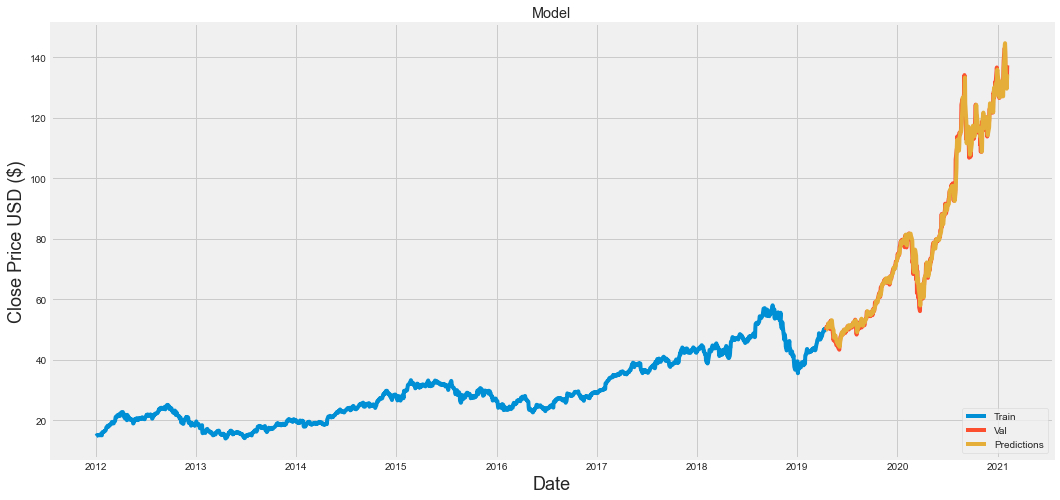

In [32]:
# Entrenamos modelos independientes para los diferentes tickers que luego utilizaremos en el multi input
models['AAPL'] = entrenarModelo('AAPL', callbacks=[es], window_size=window_size, forecastDays=1)

Crear serie MSFT 
Crear modelo MSFT 
Entrenar modelo 
Epoch 1/30
50/50 [==============================] - 3s 70ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0143 - val_mae: 0.0143
Epoch 2/30
50/50 [==============================] - 3s 53ms/step - loss: 0.0058 - mae: 0.0058 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 3/30
50/50 [==============================] - 3s 61ms/step - loss: 0.0056 - mae: 0.0056 - val_loss: 0.0101 - val_mae: 0.0101
Epoch 4/30
50/50 [==============================] - 4s 73ms/step - loss: 0.0050 - mae: 0.0050 - val_loss: 0.0098 - val_mae: 0.0098
Epoch 5/30
50/50 [==============================] - 4s 72ms/step - loss: 0.0051 - mae: 0.0051 - val_loss: 0.0168 - val_mae: 0.0168
Epoch 6/30
50/50 [==============================] - 4s 73ms/step - loss: 0.0049 - mae: 0.0049 - val_loss: 0.0094 - val_mae: 0.0094
Epoch 7/30
50/50 [==============================] - 4s 72ms/step - loss: 0.0051 - mae: 0.0051 - val_loss: 0.0110 - val_mae: 0.0110
Epoch 8/30
50/50 [===========

C:\ProgramData\Anaconda3\envs\dhdsblendv5\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


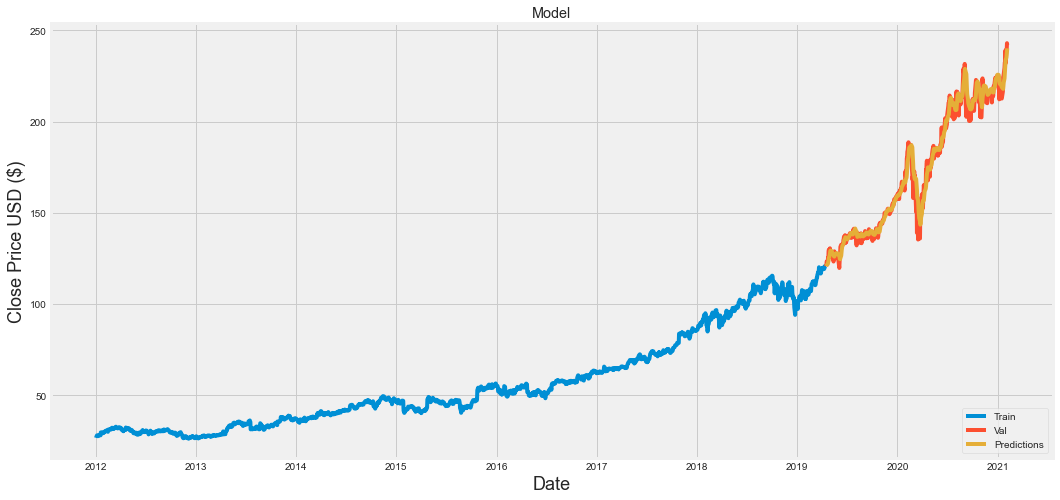

In [33]:
models['MSFT'] = entrenarModelo('MSFT', callbacks=[es], window_size=window_size, forecastDays=1)

Entrenar modelo multi input 
Epoch 1/30
50/50 [==============================] - 7s 132ms/step - loss: 0.0411 - mae: 0.0411 - val_loss: 0.0196 - val_mae: 0.0196
Epoch 2/30
50/50 [==============================] - 4s 85ms/step - loss: 0.0074 - mae: 0.0074 - val_loss: 0.0122 - val_mae: 0.0122
Epoch 3/30
50/50 [==============================] - 5s 95ms/step - loss: 0.0062 - mae: 0.0062 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 4/30
50/50 [==============================] - 5s 96ms/step - loss: 0.0062 - mae: 0.0062 - val_loss: 0.0114 - val_mae: 0.0114
Epoch 5/30
50/50 [==============================] - 5s 97ms/step - loss: 0.0059 - mae: 0.0059 - val_loss: 0.0126 - val_mae: 0.0126
Epoch 6/30
50/50 [==============================] - 5s 98ms/step - loss: 0.0051 - mae: 0.0051 - val_loss: 0.0098 - val_mae: 0.0098
Epoch 7/30
50/50 [==============================] - 5s 95ms/step - loss: 0.0056 - mae: 0.0056 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 8/30
50/50 [==============================] - 5

C:\ProgramData\Anaconda3\envs\dhdsblendv5\lib\site-packages\ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


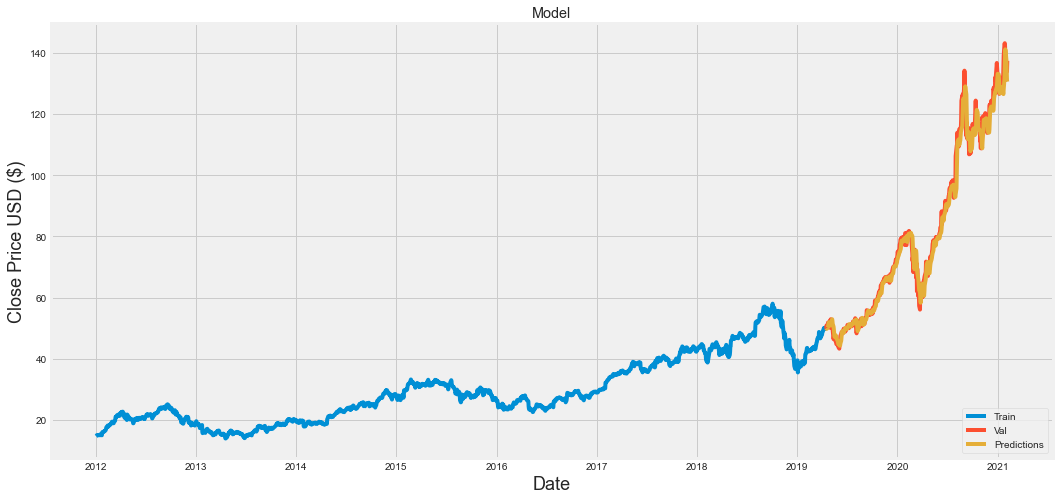

In [34]:
multi_input_model, history, valid = entrenarModeloMI('AAPL', models, callbacks=[es], window_size=window_size, forecastDays=1)

ticker: AAPL 
ticker: MSFT 
MSFT prediccion (scaled): [[-0.45231172]] 
MSFT prediccion (inverse): [[183.9345]] 
AAPL prediccion (scaled): [[0.76598704]] 
AAPL prediccion (inverse): [[135.1123]] 
ticker: AAPL 
ticker: MSFT 
MSFT prediccion (scaled): [[-0.45098034]] 
MSFT prediccion (inverse): [[183.98863]] 
AAPL prediccion (scaled): [[0.8114573]] 
AAPL prediccion (inverse): [[136.67603]] 
ticker: AAPL 
ticker: MSFT 
MSFT prediccion (scaled): [[-0.4045595]] 
MSFT prediccion (inverse): [[185.87656]] 
AAPL prediccion (scaled): [[0.815885]] 
AAPL prediccion (inverse): [[136.8283]] 
ticker: AAPL 
ticker: MSFT 
MSFT prediccion (scaled): [[-0.3129724]] 
MSFT prediccion (inverse): [[189.60141]] 
AAPL prediccion (scaled): [[0.8036584]] 
AAPL prediccion (inverse): [[136.40782]] 
ticker: AAPL 
ticker: MSFT 
MSFT prediccion (scaled): [[-0.19430418]] 
MSFT prediccion (inverse): [[194.42766]] 
AAPL prediccion (scaled): [[0.7912518]] 
AAPL prediccion (inverse): [[135.98116]] 


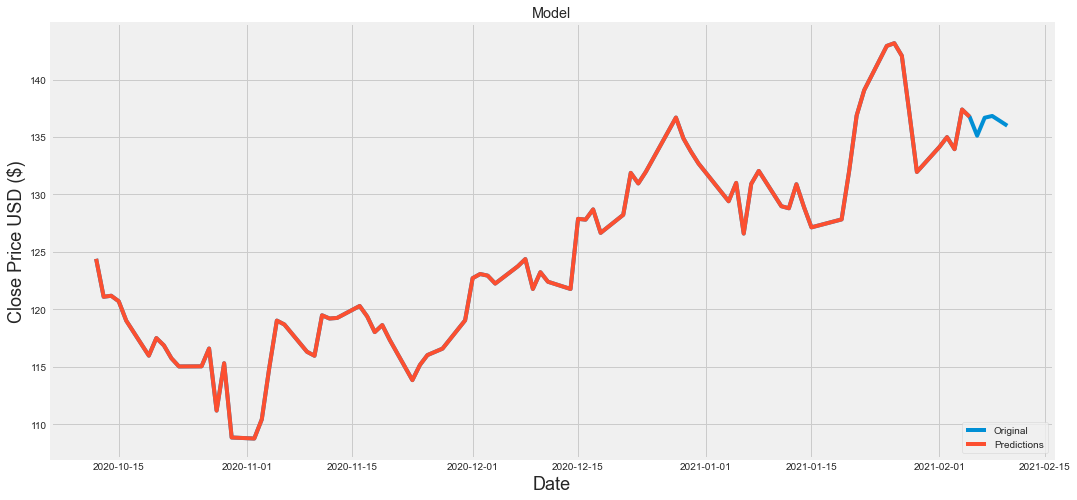

{'predictions':                  Close
 Date                  
 2021-02-06  135.112305
 2021-02-07  136.676025
 2021-02-08  136.828293
 2021-02-09  136.407822
 2021-02-10  135.981155}

In [36]:
forecast('AAPL', ['MSFT'], forecastPeriods=5, forecastDays=1)